In [3]:
!git clone https://github.com/bowman-aikium/aikium_thermal_stability
%cd aikium_thermal_stability

Cloning into 'aikium_thermal_stability'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 68 (delta 19), reused 58 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 3.24 MiB | 25.96 MiB/s, done.
Resolving deltas: 100% (19/19), done.
/content/aikium_thermal_stability/aikium_thermal_stability


In [4]:
!pip install sympy==1.12
import sympy
print(sympy.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 127.2 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3
    Uninstalling sympy-1.13.3:
      Successfully uninstalled sympy-1.13.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.8.0+cu126 requires sympy>=1.13.3, but you have sympy 1.12 which is incompatible.
1.12


In [5]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from google.colab import files



# Import from your Model folder
from Model.model import thermalMLP, ProteinTmDataset


In [9]:
embedding_np = np.load("/content/esm2_embeddings_with_ids.npz", allow_pickle=True)
dataset_df = pd.read_csv("/content/Stratified_data.csv")

embedding = embedding_np["embeddings"]   # shape: (N, hidden_dim)
ids = embedding_np["ids"]

emb_df = pd.DataFrame({
    "ID": ids,
    "embedding": list(embedding)
})

emb_df["ID"] = emb_df["ID"].astype(int)
dataset_df["ID"] = dataset_df["ID"].astype(int)
merged = emb_df.merge(dataset_df, on="ID")
merged


,ID,embedding,Tm,Sequence,From,AA_length,MW
0,117012,"[3.4952238, 2.9369724, -3.406106, -1.0034976, ...",45.556042,MKWAYKEENNFEKRRAEGDKIRRKYPDRIPVIVEKAPKSKLHDLDK...,meltome,123,14.763731
1,313786,"[2.2217994, -2.0552912, -0.14634663, 1.3754547...",43.863329,MVKATNVDLSLEDIISKTRKTTGSIQKKSFGGARRGNTRPTGLPRR...,meltome,240,25.695370
2,169171,"[3.0030677, 4.205013, 4.074065, 0.7811, -6.895...",43.574470,MPRANEIKKGMVLNYNGKLLLVKDIDIQSPTARGAATLYKMRFSDV...,meltome,190,21.532381
3,227821,"[4.7244706, -0.123155594, 1.057647, 4.5875287,...",40.496359,MTKSELIERMLTKQPQLSAKDVELAVKTILDHMSQSLSTGERIEIR...,meltome,96,10.757199
4,97927,"[2.16275, -1.2902148, 2.1692014, 0.009807652, ...",37.073883,MRQVVLDTETTGIGAEKGHRIIEIGCVELIDRKLTGRHYHQYVNPQ...,meltome,234,26.063256
...,...,...,...,...,...,...,...
23415,200713,"[3.211512, 0.9198779, -0.08337058, -1.2356853,...",86.289547,MTVRQVLVHKGGGVHAIHPEATVLDALRKLAEHDIGALLVMEGERL...,meltome,143,15.916415
23416,267005,"[-1.4136505, -2.4800174, 0.06798242, 2.689519,...",88.057949,MTGLELLAVALGMRHGVDPDHLAAVDGLSRVRPSPLNGVLFALGHG...,meltome,220,22.874996
23417,269836,"[2.5266905, -5.975683, -3.1002605, 1.2522675, ...",88.583454,MASLSFMIKEYNDYYIIDFERPVRKFSSAPFNGGVGTSLRYINRTV...,meltome,215,24.262483
23418,298355,"[0.30273947, 2.1589444, -0.4573475, -0.4192088...",86.755190,MRFKAELMNAPEMRRALYRIAHEIVEANKGTEGLALVGIHTRGIPL...,meltome,181,20.466363


In [10]:
def train_and_eval(params, input_dim, train_loader, val_loader):

    model = thermalMLP(
        input_dim=input_dim,
        hidden_sizes=params["hidden_sizes"],
        activation=params["activation"],
        dropout=params["dropout"]
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=params["lr"])

    train_losses = []
    val_losses = []

    best_val_loss = float("inf")
    best_model_path = "best_model.pth"

    for epoch in range(params["epochs"]):
        # ---- Training ----
        model.train()
        epoch_train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # ---- Validation ----
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                epoch_val_loss += criterion(preds, yb).item()
        val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{params['epochs']} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"✅ Saved new best model at epoch {epoch+1} with Val Loss {val_loss:.4f}")

    return train_losses, val_losses, best_model_path

In [11]:
embeddings = np.stack(merged["embedding"].values)
Tm = merged["Tm"].values
input_dim = embeddings.shape[1]

X_train, X_val, y_train, y_val = train_test_split(embeddings, Tm, test_size=0.2, random_state=42)

train_ds = ProteinTmDataset(X_train, y_train)
val_ds = ProteinTmDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size= 128 * 8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128 * 4)


Epoch 1/100 | Train Loss: 1146.0351 | Val Loss: 161.9457
✅ Saved new best model at epoch 1 with Val Loss 161.9457
Epoch 2/100 | Train Loss: 155.9008 | Val Loss: 112.4537
✅ Saved new best model at epoch 2 with Val Loss 112.4537
Epoch 3/100 | Train Loss: 106.0631 | Val Loss: 96.4905
✅ Saved new best model at epoch 3 with Val Loss 96.4905
Epoch 4/100 | Train Loss: 86.9494 | Val Loss: 83.7561
✅ Saved new best model at epoch 4 with Val Loss 83.7561
Epoch 5/100 | Train Loss: 76.4589 | Val Loss: 75.5246
✅ Saved new best model at epoch 5 with Val Loss 75.5246
Epoch 6/100 | Train Loss: 68.3061 | Val Loss: 68.7158
✅ Saved new best model at epoch 6 with Val Loss 68.7158
Epoch 7/100 | Train Loss: 60.6762 | Val Loss: 62.3504
✅ Saved new best model at epoch 7 with Val Loss 62.3504
Epoch 8/100 | Train Loss: 54.2164 | Val Loss: 57.9309
✅ Saved new best model at epoch 8 with Val Loss 57.9309
Epoch 9/100 | Train Loss: 48.7153 | Val Loss: 52.0722
✅ Saved new best model at epoch 9 with Val Loss 52.0722
Ep

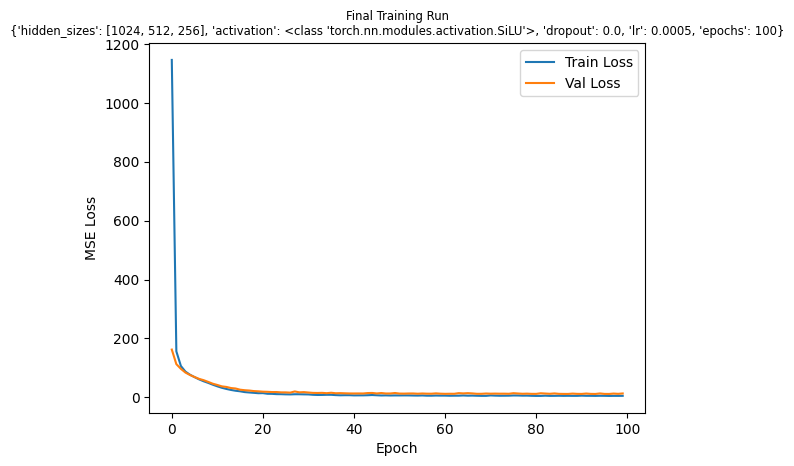

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Final training with train+val complete, plot and model saved.


In [12]:
# Best config from your sweep
best_params = {
    "hidden_sizes": [1024, 512, 256],
    "activation": nn.SiLU,
    "dropout": 0.0,
    "lr": 5e-4,
    "epochs": 100
}

# Train one final time on train/val split
final_train_loss, final_val_loss, best_model_path = train_and_eval(
    best_params, input_dim, train_loader, val_loader
)

# Plot Training vs Validation Loss
plt.figure()
plt.plot(final_train_loss, label="Train Loss")
plt.plot(final_val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title(f"Final Training Run\n{best_params}", fontsize="small")
plt.legend()

# Save + show
plt.savefig("final_train_val_loss.png", dpi=300, bbox_inches="tight")
plt.show()

files.download(best_model_path)
print("✅ Final training with train+val complete, plot and model saved.")